In [1]:
# full version, where data is loaded and preprocessed, models are built etc.
# 10 runs of each model

In [2]:
# Set seed
# SEED = 3
import random
import numpy as np
import tensorflow as tf # tf backend

# random.seed(SEED)
# np.random.seed(SEED)
# tf.random.set_seed(SEED)

# Imports
from danlp.models.embeddings  import load_wv_with_gensim
from gensim.models import KeyedVectors
import json
from keras import layers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, plot_model
import matplotlib.pyplot as plt
import nltk
import os
import pandas as pd
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from statistics import mode
from tqdm import tqdm
import utils

## Load data

In [3]:
# Load data
X_train_orig, X_test_orig, y_train_orig, y_test_orig = utils.load_dkhate(test_size=0.2)

pd.DataFrame([X_train_orig, y_train_orig]).T.tail()

,tweet,label
id,,
2378,Hørt!,0
1879,Min reaktion hvis jeg var Svensker,0
42,hey champ Vil du ikke smide et link til hvor d...,0
457,Hvis du melder en for vold eller voldtægt og d...,1
3108,"Vi betaler for omkring 4mb ned, 500kb op men f...",0


## EDA

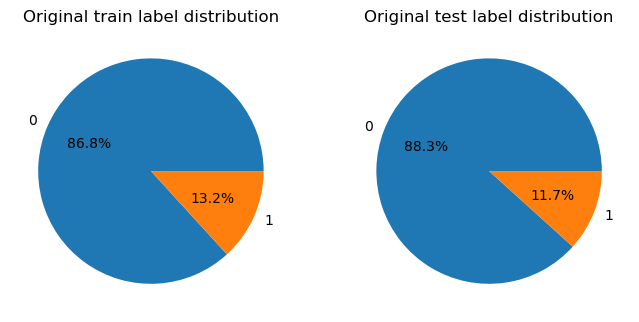

In [4]:
# plot label distribution
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].pie(y_train_orig.value_counts().values,
        labels = y_train_orig.value_counts().index,
        autopct='%1.1f%%')
axes[0].set_title("Original train label distribution")

axes[1].pie(y_test_orig.value_counts().values,
        labels = y_test_orig.value_counts().index,
        autopct='%1.1f%%')
axes[1].set_title("Original test label distribution")

plt.savefig("plots/original_label_distributions.png")
plt.show()

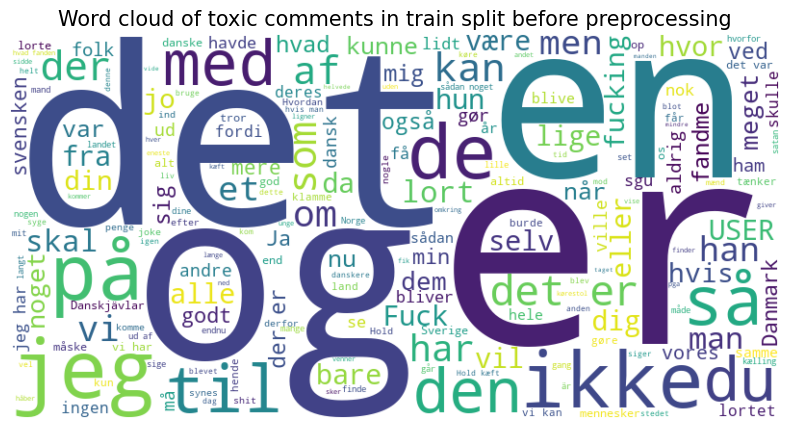

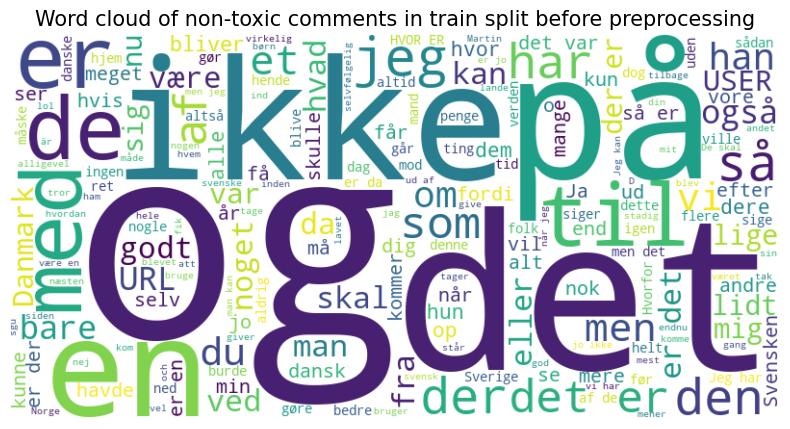

In [5]:
# plot word clouds
utils.plot_wordcloud(
    word_cloud=utils.create_wordcloud(X_train_orig, y_train_orig, mask=1), title="Word cloud of toxic comments in train split before preprocessing",
    save=True, file_name="toxic_cloud_before_preprocessing.png"
    )

utils.plot_wordcloud(
    word_cloud=utils.create_wordcloud(X_train_orig, y_train_orig, mask=0), 
    title="Word cloud of non-toxic comments in train split before preprocessing",
    save=True, file_name="nontoxic_cloud_before_preprocessing.png"
    )

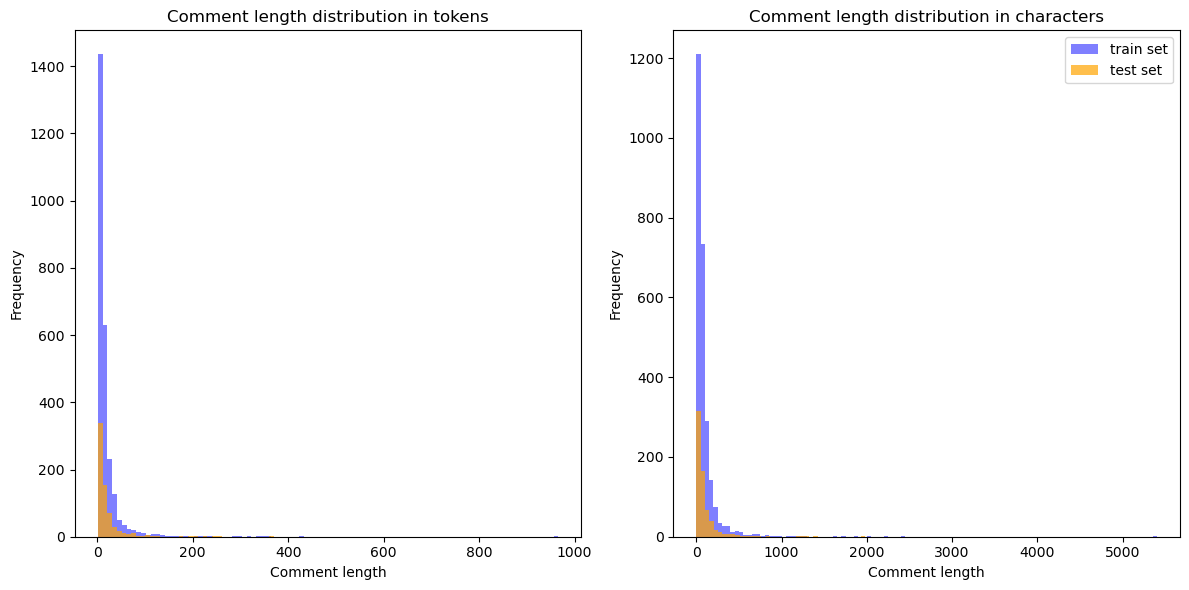

max length of tweet

         non-toxic    toxic
test:    370 words    253 words
train:   966 words    432 words


In [6]:
# plot the distribution of the length of the comments for both toxic and non-toxic classes

# calculate word lengths of both train and test set
tweet_wlengths_train = [len(tweet.split()) for tweet in X_train_orig]
tweet_wlengths_test = [len(tweet.split()) for tweet in X_test_orig]

# calculate char lengths of both train and test set
tweet_clengths_train = [len(tweet) for tweet in X_train_orig]
tweet_clengths_test = [len(tweet) for tweet in X_test_orig]

# plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(tweet_wlengths_train, bins=max(tweet_wlengths_train)//10, color='blue', alpha=0.5, label='train set')
plt.hist(tweet_wlengths_test, bins=max(tweet_wlengths_test)//10, color='orange', alpha=0.7, label='test set')
plt.title('Comment length distribution in tokens')
plt.xlabel('Comment length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(tweet_clengths_train, bins=max(tweet_clengths_train)//50, color='blue', alpha=0.5, label='train set')
plt.hist(tweet_clengths_test, bins=max(tweet_clengths_test)//50, color='orange', alpha=0.7, label='test set')
plt.title('Comment length distribution in characters')
plt.xlabel('Comment length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.legend()
plt.savefig("plots/comment_lengths.png")
plt.show()

# print max lengths
tweet_wlengths_toxic_train = [len(tweet.split()) for tweet in X_train_orig[y_train_orig==1]]
tweet_wlengths_nontoxic_train = [len(tweet.split()) for tweet in X_train_orig[y_train_orig==0]]
tweet_wlengths_toxic_test = [len(tweet.split()) for tweet in X_test_orig[y_test_orig==1]]
tweet_wlengths_nontoxic_test = [len(tweet.split()) for tweet in X_test_orig[y_test_orig==0]]

print("max length of tweet\n")
print("         non-toxic    toxic")
print("test:   ", max(tweet_wlengths_nontoxic_test), "words   ", max(tweet_wlengths_toxic_test), "words")
print("train:  ", max(tweet_wlengths_nontoxic_train), "words   ", max(tweet_wlengths_toxic_train), "words")

## Preprocessing

In [7]:
stop_words = nltk.corpus.stopwords.words('danish')

# preprocess train and test set
X_train_preproc = X_train_orig.apply(lambda text: utils.preprocess(text, stopwords=stop_words, to_string=True))
X_test_preproc = X_test_orig.apply(lambda text: utils.preprocess(text, stopwords=stop_words, to_string=True))

print("Before preprocessing:")
display(pd.DataFrame([X_train_orig, y_train_orig]).T.tail())
print(f"Vocab size: {len(utils.get_vocab(X_train_orig, are_tokens=False)):,}")

print("\n\nAfter preprocessing:")
display(pd.DataFrame([X_train_preproc, y_train_orig]).T.tail())
print(f"Vocab size: {len(utils.get_vocab(X_train_preproc, are_tokens=False)):,}")

Before preprocessing:


,tweet,label
id,,
2378,Hørt!,0
1879,Min reaktion hvis jeg var Svensker,0
42,hey champ Vil du ikke smide et link til hvor d...,0
457,Hvis du melder en for vold eller voldtægt og d...,1
3108,"Vi betaler for omkring 4mb ned, 500kb op men f...",0


Vocab size: 13,117


After preprocessing:


,tweet,label
id,,
2378,hørt,0
1879,reaktion svensker,0
42,hey champ smide link ser hearthstone henne,0
457,melder vold voldtægt viser sandt beviser diver...,1
3108,betaler omkring mb kb får nok tættere kb kb be...,0


Vocab size: 8,918


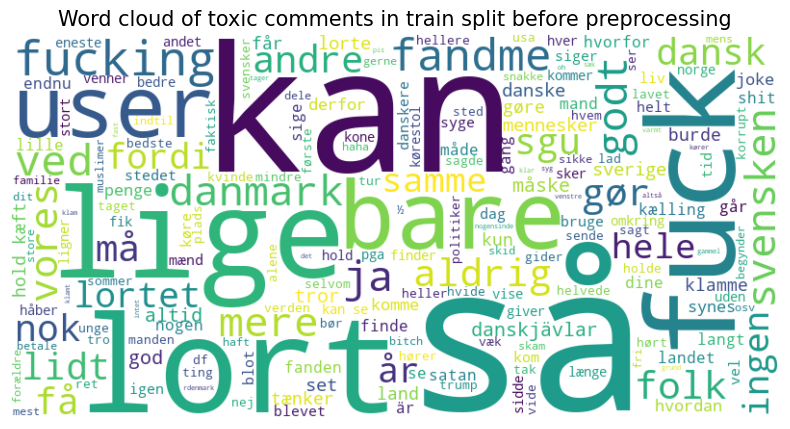

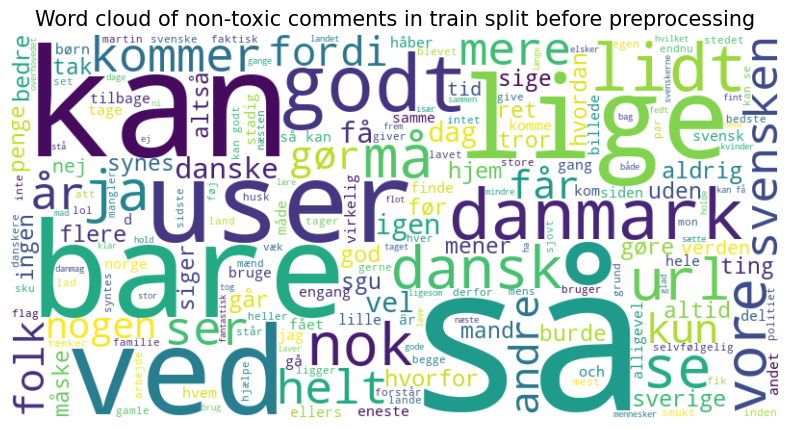

In [8]:
# plot word clouds after preprocessing
utils.plot_wordcloud(
    word_cloud=utils.create_wordcloud(X_train_preproc, y_train_orig, mask=1), 
    title="Word cloud of toxic comments in train split before preprocessing",
    save=True, file_name="toxic_cloud_after_preprocessing.png"
    )

utils.plot_wordcloud(
    word_cloud=utils.create_wordcloud(X_train_preproc, y_train_orig, mask=0), 
    title="Word cloud of non-toxic comments in train split before preprocessing",
    save=True, file_name="non-toxic_cloud_after_preprocessing.png"
    )

## Prepare data for models

In [9]:
# Ensure that there are no null values
if X_train_preproc.isnull().any() or X_test_preproc.isnull().any():
    raise ValueError("There are missing values in the data.")

# Print shapes
print("Shapes:")
print(X_train_preproc.shape, y_train_orig.shape)
print(X_test_preproc.shape, y_test_orig.shape)

Shapes:
(2631,) (2631,)
(658,) (658,)


In [10]:
# fix class imbalance

# vectorize X_train
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train_preproc)

# oversample the minority class
X_train_oversampled, y_train_oversampled = utils.oversample_data(X_train_vec, y_train_orig, strategy=0.5, smote=False) 

# convert back to text
X_train_oversampled = pd.Series([' '.join(vectorizer.inverse_transform(vector)[0]) for vector in X_train_oversampled])

pd.DataFrame([X_train_oversampled, y_train_oversampled]).T.head()

,Unnamed 0,label
0,hahaha,0
1,user føler svært så prøv flytte afrika får str...,0
2,endnu barriere bønder uden eu,0
3,eneste møde ved snuskede stambar aalborg altid...,0
4,godt forøvrigt taget dokumentarprogram svensk ...,0


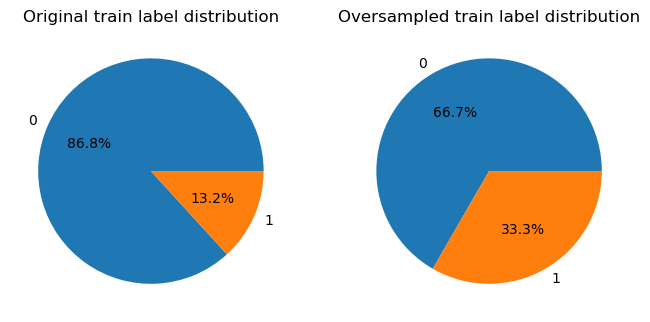

In [11]:
# plot label distribution
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].pie(y_train_orig.value_counts().values,
        labels = y_train_orig.value_counts().index,
        autopct='%1.1f%%')
axes[0].set_title("Original train label distribution")

axes[1].pie(y_train_oversampled.value_counts().values,
        labels = y_train_oversampled.value_counts().index,
        autopct='%1.1f%%')
axes[1].set_title("Oversampled train label distribution")

plt.savefig("plots/new_label_distributions.png")
plt.show()

In [12]:
# pickle the preprocessed and oversampled splits
dataset_splits = {
    "X training preprocessed and oversampled": X_train_oversampled,
    "y training preprocessed and oversampled": y_train_oversampled,
    "X test preprocessed": X_test_preproc,
    "y test": y_test_orig
}

with open("data/dataset_splits.pkl", "wb") as f:
    pickle.dump(dataset_splits, f)

In [13]:
# rename splits (remove suffixes)
X_train = X_train_oversampled
y_train = y_train_oversampled
X_test = X_test_preproc
y_test = y_test_orig

## Baseline model (logistic regression with unigrams)

In [14]:
# vectorization
vectorizer = TfidfVectorizer(ngram_range=(1,1)) # unigrams
vectorizer = vectorizer.fit(X_train)
feat_names = vectorizer.get_feature_names_out()
X_train_baseline = vectorizer.transform(X_train)
X_test_baseline = vectorizer.transform(X_test)

print(f"{len(feat_names):,} unigrams in total (= number of features)\n")
print("First 5 unigrams:")
for unigram in feat_names[:5]:
    print(unigram)

print("\nShapes:")
print(X_train_baseline.shape, y_train.shape)
print(X_test_baseline.shape, y_test.shape)

8,785 unigrams in total (= number of features)

First 5 unigrams:
aa
aaaaah
aaaarg
aaalt
aalborg

Shapes:
(3424, 8785) (3424,)
(658, 8785) (658,)


0
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       581
           1       0.74      0.18      0.29        77

    accuracy                           0.90       658
   macro avg       0.82      0.59      0.62       658
weighted avg       0.88      0.90      0.87       658



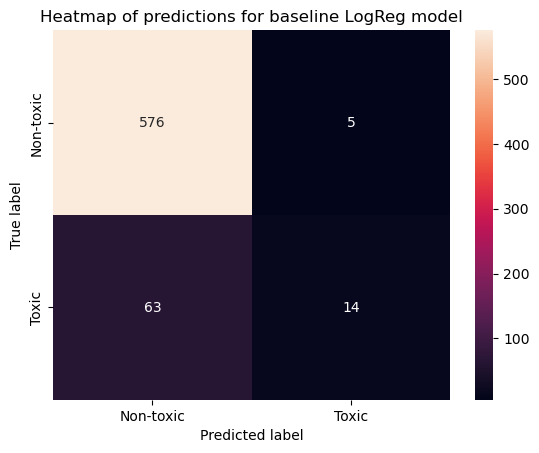

________________________________________________________________________________________________________________________________________________________________________________________________________
1
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       581
           1       0.74      0.18      0.29        77

    accuracy                           0.90       658
   macro avg       0.82      0.59      0.62       658
weighted avg       0.88      0.90      0.87       658



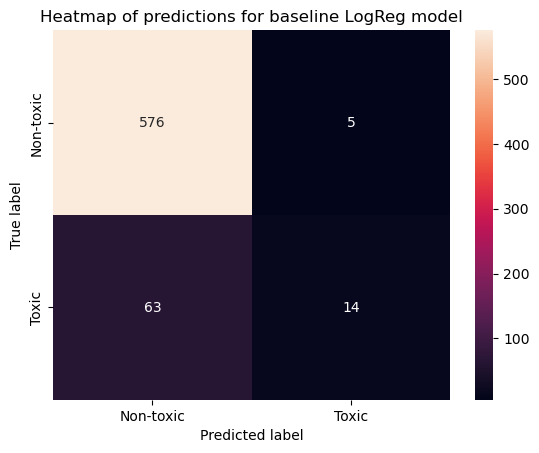

________________________________________________________________________________________________________________________________________________________________________________________________________
2
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       581
           1       0.74      0.18      0.29        77

    accuracy                           0.90       658
   macro avg       0.82      0.59      0.62       658
weighted avg       0.88      0.90      0.87       658



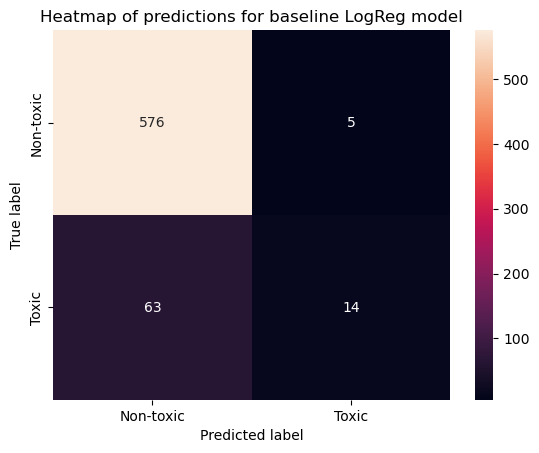

________________________________________________________________________________________________________________________________________________________________________________________________________
3
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       581
           1       0.74      0.18      0.29        77

    accuracy                           0.90       658
   macro avg       0.82      0.59      0.62       658
weighted avg       0.88      0.90      0.87       658



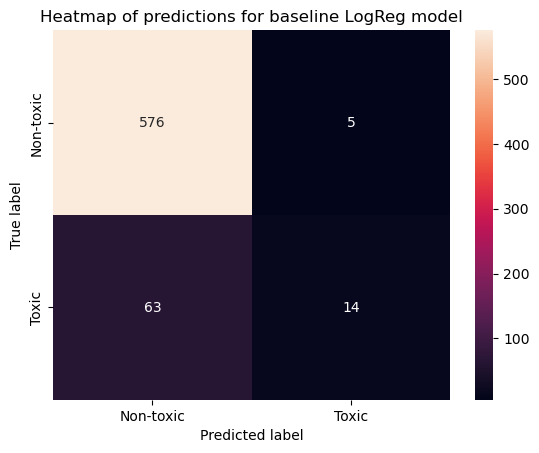

________________________________________________________________________________________________________________________________________________________________________________________________________
4
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       581
           1       0.74      0.18      0.29        77

    accuracy                           0.90       658
   macro avg       0.82      0.59      0.62       658
weighted avg       0.88      0.90      0.87       658



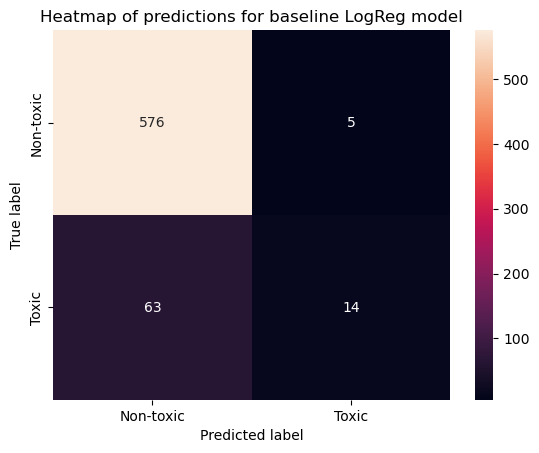

________________________________________________________________________________________________________________________________________________________________________________________________________
5
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       581
           1       0.74      0.18      0.29        77

    accuracy                           0.90       658
   macro avg       0.82      0.59      0.62       658
weighted avg       0.88      0.90      0.87       658



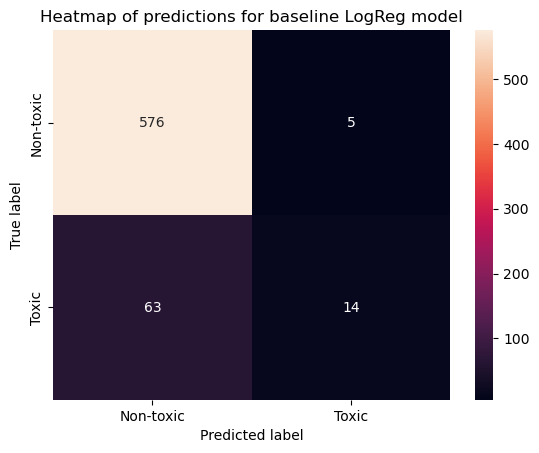

________________________________________________________________________________________________________________________________________________________________________________________________________
6
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       581
           1       0.74      0.18      0.29        77

    accuracy                           0.90       658
   macro avg       0.82      0.59      0.62       658
weighted avg       0.88      0.90      0.87       658



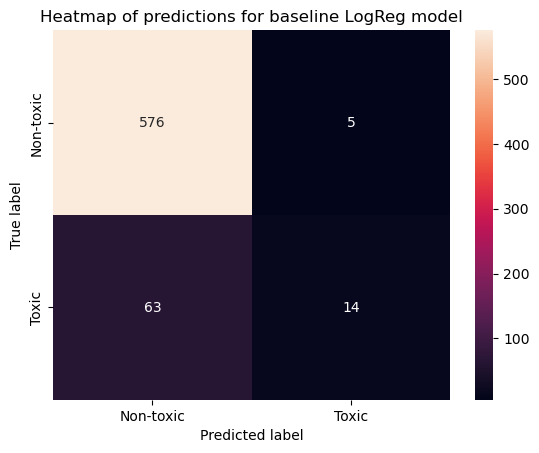

________________________________________________________________________________________________________________________________________________________________________________________________________
7
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       581
           1       0.74      0.18      0.29        77

    accuracy                           0.90       658
   macro avg       0.82      0.59      0.62       658
weighted avg       0.88      0.90      0.87       658



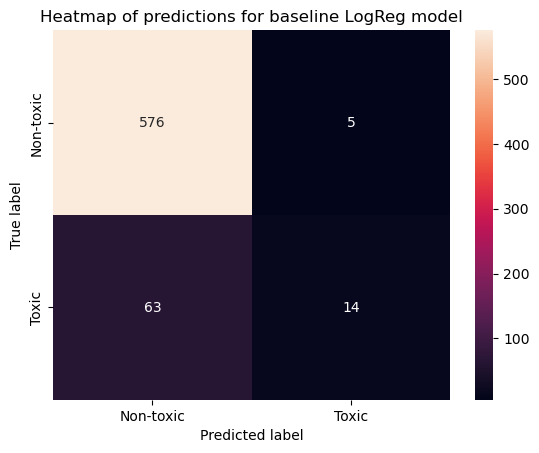

________________________________________________________________________________________________________________________________________________________________________________________________________
8
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       581
           1       0.74      0.18      0.29        77

    accuracy                           0.90       658
   macro avg       0.82      0.59      0.62       658
weighted avg       0.88      0.90      0.87       658



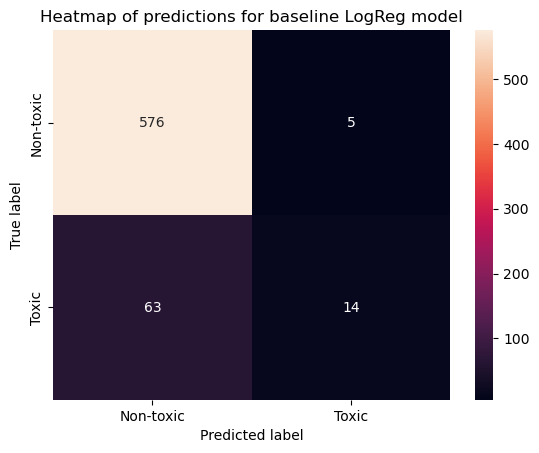

________________________________________________________________________________________________________________________________________________________________________________________________________
9
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       581
           1       0.74      0.18      0.29        77

    accuracy                           0.90       658
   macro avg       0.82      0.59      0.62       658
weighted avg       0.88      0.90      0.87       658



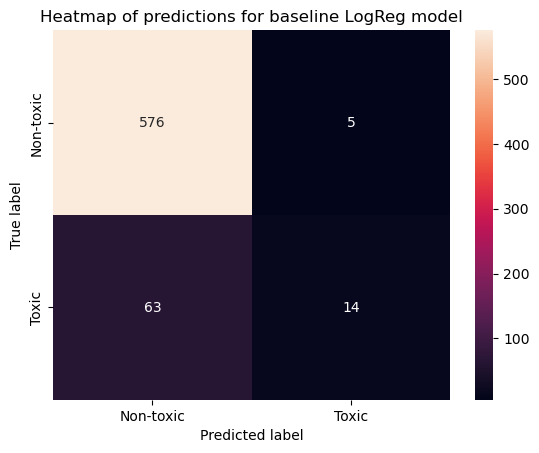

________________________________________________________________________________________________________________________________________________________________________________________________________


In [15]:
# TODO 10 versions here!
# should I do that here? I get the same results? should we change where the data is split and oversampled?

for i in range(10): # 10 different initializations of the baseline model
    print(i)
    # define and fit model
    lr = LogisticRegression()
    lr.fit(X_train_baseline, y_train)

    # make predictions and evaluate model
    lr_pred = lr.predict(X_test_baseline)
    print(classification_report(y_test, lr_pred))

    lr_cm = confusion_matrix(y_test, lr_pred, labels=lr.classes_)
    utils.plot_heatmap(lr_cm, title="Heatmap of predictions for baseline LogReg model", save=True, file_name="logreg_heatmap.png")
    print("_"*200)

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       581
           1       0.74      0.18      0.29        77

    accuracy                           0.90       658
   macro avg       0.82      0.59      0.62       658
weighted avg       0.88      0.90      0.87       658



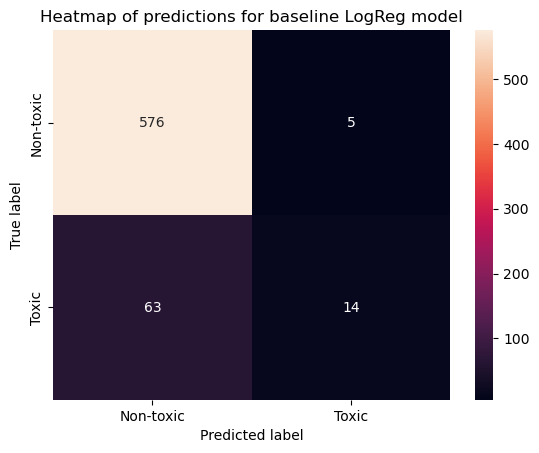

In [16]:
# log reg baseline

# define and fit model
lr = LogisticRegression()
lr.fit(X_train_baseline, y_train)

# make predictions and evaluate model
lr_pred = lr.predict(X_test_baseline)
print(classification_report(y_test, lr_pred))

lr_cm = confusion_matrix(y_test, lr_pred, labels=lr.classes_)
utils.plot_heatmap(lr_cm, title="Heatmap of predictions for baseline LogReg model", save=True, file_name="logreg_heatmap.png")

In [17]:
# save baseline
with open("models/baseline_lr.pkl", "wb") as f:
    pickle.dump(lr, f)

# save vectorized version of X_test
with open("data/X_test_baseline.pkl", "wb") as f:
    pickle.dump(X_test_baseline, f)

## CNN

In [18]:
# prepare data for model

NUM_WORDS = 10000

# tokenization
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)

# pad sequences to max length
MAXLEN = max([len(x) for x in X_train_tokenized])
print(f"Max {MAXLEN} tokens in train")
X_train_padded = pad_sequences(X_train_tokenized, maxlen=MAXLEN, padding="post")
X_test_padded = pad_sequences(X_test_tokenized, maxlen=MAXLEN, padding="post")

# check shapes
print("\nShapes:")
print(X_train_padded.shape, y_train.shape)
print(X_test_padded.shape, y_test.shape)

Max 322 tokens in train

Shapes:
(3424, 322) (3424,)
(658, 322) (658,)


In [19]:
# load pre-trained embeddings

# CONLL17 embeddings
if "word2vec.model" not in os.listdir("embeddings") or "word2vec.model.vectors.npy" not in os.listdir("embeddings"):
    word_embeddings = load_wv_with_gensim('conll17.da.wv')
    word_embeddings.save("embeddings/word2vec.model")
word_embeddings = KeyedVectors.load("embeddings/word2vec.model")

# # Wiki embeddings
# if "word2vecwiki.model" not in os.listdir("embeddings") or "word2vecwiki.model.vectors.npy" not in os.listdir("embeddings"):
#     word_embeddings = load_wv_with_gensim('wiki.da.wv')
#     word_embeddings.save("embeddings/word2vecwiki.model")
# word_embeddings = KeyedVectors.load("embeddings/word2vecwiki.model")

In [20]:
# explore embeddings

print("Examples of words in embeddings vocabulary:")
for x in list(word_embeddings.vocab.keys())[:15]:
    print(x) 

print("\n___ is to 'england' as 'københavn' is to 'danmark':")
for x in word_embeddings.most_similar(positive=['københavn', 'england'], negative=['danmark'], topn=3):
    print(x)

print("\n___ is to 'kvinde' as 'dreng' is to 'mand':")
for x in word_embeddings.most_similar(positive=['dreng', 'kvinde'], negative=['mand'], topn=3):
    print(x)

Examples of words in embeddings vocabulary:
</s>
,
.
i
og
af
er
at
til
på
en
med
for
det
-

___ is to 'england' as 'københavn' is to 'danmark':
('london', 0.7156291604042053)
('edinburgh', 0.6790332198143005)
('woolwich', 0.6561343669891357)

___ is to 'kvinde' as 'dreng' is to 'mand':
('pige', 0.8950952291488647)
('skolepige', 0.792621910572052)
('legetøjsfigur', 0.7810863852500916)


In [21]:
# create word to embedding vector map
embeddings_index = {}
for w in word_embeddings.vocab.keys():
    embeddings_index[w] = word_embeddings[w]

In [22]:
# get dimension of embeddings
EMB_DIM = embeddings_index.get('er').shape[0]
print("Embedding dimension:", EMB_DIM)

Embedding dimension: 100


In [23]:
# map words in train to pretrained word embeddings
hits, misses = 0, 0
misses_list = []

embedding_matrix = np.zeros((NUM_WORDS, EMB_DIM)) # empty embedding matrix with zeros
for word, i in tokenizer.word_index.items(): # for each word in training vocab (tokenizer)
    if i >= NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word) # put it in the matrix
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        misses_list.append(word)
        
# if a word is not in the pretrained embedding, the entry will remain zero
print(f"Converted {hits:,} words ({misses:,} misses)")

# save misses to txt file
with open('word_embedding_misses.txt', 'w') as f:
    for miss in sorted(misses_list):
        f.write(miss)
        f.write("\n")

Converted 7,794 words (992 misses)


In [25]:
cnn_results = {}

for i in tqdm(range(1, 11)): # 10 different initializations
    print(f"MODEL NO. {i}/10")
    
    # Define network
    cnn = Sequential()
    cnn.add(layers.Input(shape=(None,), dtype="int64")) # input layer
    cnn.add(layers.Embedding( # embedding layer using pretrained embeddings
        input_dim=NUM_WORDS, 
        output_dim=EMB_DIM, 
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), 
        trainable=True))

    # add layers
    cnn.add(layers.Conv1D(128, 5, activation="relu"))
    cnn.add(layers.GlobalMaxPooling1D())
    cnn.add(layers.Dense(10, activation="relu"))
    cnn.add(layers.Dense(1, activation="sigmoid"))

    # compile model
    cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

    # # summarize model
    # cnn.summary()
    
    # fit model
    history = cnn.fit(X_train_padded, y_train, 
                        batch_size=128,
                        epochs=10,
                        verbose=False,
                        validation_data=(X_test_padded, y_test))

    # make predictions
    p = cnn.predict(X_test_padded)
    pred = np.where(p > .5, 1, 0)
    
    # save results
    cnn_results["model"+str(i)] = {
        "name": "model"+str(i),
        "proba": p,
        "pred": pred
    }
    
    # save model
    cnn.save(f'models/initializations/cnn{i}.keras')
    
    print("done!")
    print("_"*200)

  0%|          | 0/10 [00:00<?, ?it/s]

MODEL NO. 1/10
21/21 [==============================] - 0s 11ms/step


 10%|█         | 1/10 [00:42<06:19, 42.22s/it]

done!
________________________________________________________________________________________________________________________________________________________________________________________________________
MODEL NO. 2/10
21/21 [==============================] - 0s 12ms/step


 20%|██        | 2/10 [01:23<05:33, 41.68s/it]

done!
________________________________________________________________________________________________________________________________________________________________________________________________________
MODEL NO. 3/10
21/21 [==============================] - 0s 11ms/step


 30%|███       | 3/10 [02:03<04:44, 40.69s/it]

done!
________________________________________________________________________________________________________________________________________________________________________________________________________
MODEL NO. 4/10
21/21 [==============================] - 0s 9ms/step


 40%|████      | 4/10 [02:45<04:09, 41.55s/it]

done!
________________________________________________________________________________________________________________________________________________________________________________________________________
MODEL NO. 5/10
21/21 [==============================] - 0s 10ms/step


 50%|█████     | 5/10 [03:27<03:28, 41.69s/it]

done!
________________________________________________________________________________________________________________________________________________________________________________________________________
MODEL NO. 6/10
21/21 [==============================] - 0s 9ms/step


 60%|██████    | 6/10 [04:10<02:48, 42.05s/it]

done!
________________________________________________________________________________________________________________________________________________________________________________________________________
MODEL NO. 7/10
21/21 [==============================] - 1s 12ms/step


 70%|███████   | 7/10 [04:54<02:07, 42.53s/it]

done!
________________________________________________________________________________________________________________________________________________________________________________________________________
MODEL NO. 8/10
21/21 [==============================] - 0s 9ms/step


 80%|████████  | 8/10 [05:37<01:25, 42.92s/it]

done!
________________________________________________________________________________________________________________________________________________________________________________________________________
MODEL NO. 9/10
21/21 [==============================] - 0s 10ms/step


 90%|█████████ | 9/10 [06:19<00:42, 42.49s/it]

done!
________________________________________________________________________________________________________________________________________________________________________________________________________
MODEL NO. 10/10
21/21 [==============================] - 0s 10ms/step


100%|██████████| 10/10 [07:00<00:00, 42.01s/it]

done!
________________________________________________________________________________________________________________________________________________________________________________________________________


In [26]:
cnn_results

{'model1': {'name': 'model1',
  'proba': array([[2.16168188e-03],
         [3.52616864e-03],
         [2.07532626e-02],
         [2.69270185e-02],
         [1.75461792e-05],
         [3.91717941e-01],
         [1.67175159e-01],
         [6.09068293e-03],
         [7.47332349e-02],
         [3.01693683e-03],
         [4.43226993e-02],
         [4.73228021e-04],
         [1.04414263e-04],
         [2.34704688e-02],
         [1.89108580e-01],
         [8.33945751e-01],
         [4.90444014e-03],
         [1.89108580e-01],
         [1.72254387e-02],
         [2.20249146e-02],
         [1.94451604e-02],
         [1.67175159e-01],
         [6.56521976e-01],
         [1.57527975e-03],
         [6.16202946e-04],
         [3.69895697e-01],
         [1.68500026e-03],
         [1.56186502e-02],
         [5.79658270e-01],
         [2.38560066e-02],
         [4.04558778e-01],
         [2.58665919e-01],
         [1.89108580e-01],
         [7.24142650e-04],
         [1.29163323e-04],
         [8.8272

In [27]:
for model in cnn_results.keys():
   pred = cnn_results[model]['pred']
   
   # accuracy score
   cnn_results[model]['accuracy'] = accuracy_score(y_test, pred)
   
   # f1 variants
   cnn_results[model]['f1_macro'] = f1_score(y_test, pred, average="macro")
   cnn_results[model]['f1_weighted'] = f1_score(y_test, pred, average="weighted")

In [28]:
accuracy_scores = [cnn_results[i]['accuracy'] for i in cnn_results.keys()]
print("Avg. accuracy     :", np.mean(accuracy_scores))

f1_macro_scores = [cnn_results[i]['f1_macro'] for i in cnn_results.keys()]
print("Avg. f1 (macro)   :", np.mean(f1_macro_scores))

f1_weighted_scores = [cnn_results[i]['f1_weighted'] for i in cnn_results.keys()]
print("Avg. f1 (weighted):", np.mean(f1_weighted_scores))

Avg. accuracy     : 0.9037993920972642
Avg. f1 (macro)   : 0.7268865778851203
Avg. f1 (weighted): 0.8952424783647451


In [ ]:
# .9024, .7256, .8943
# .9062, .7324, .8976
# .9038, .7269, .8952

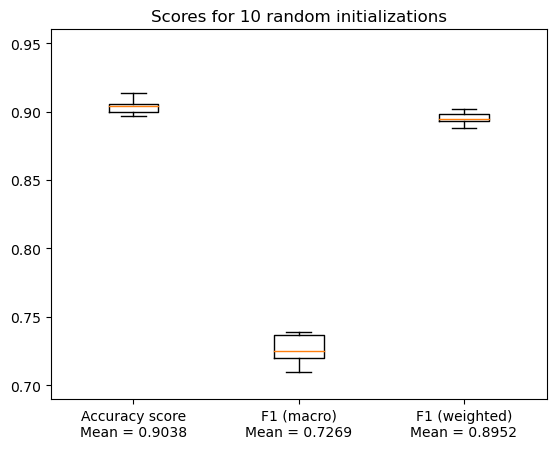

In [29]:
plt.boxplot([accuracy_scores, f1_macro_scores, f1_weighted_scores])
plt.title("Scores for 10 random initializations")
plt.ylim(0.69, 0.96)
plt.xticks(ticks=range(1,4), labels=
           [f"Accuracy score\nMean = {round(np.mean(accuracy_scores), 4)}", 
            f"F1 (macro)\nMean = {round(np.mean(f1_macro_scores), 4)}",
            f"F1 (weighted)\nMean = {round(np.mean(f1_weighted_scores), 4)}"])
plt.show()

In [30]:
# save model predictions and probabilities
with open("models/cnn_results.pkl", "wb") as f:
    pickle.dump(cnn_results, f)

# save vectorized and padded version of X_test
with open("data/X_test_cnn.pkl", "wb") as f:
    pickle.dump(X_test_padded, f)

# save tokenizer
tokenizer_json = tokenizer.to_json()
with open("models/tokenizer.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

# save maxlen value
with open("models/maxlen.txt", "w", encoding="utf-8") as f:
    f.write(str(MAXLEN))

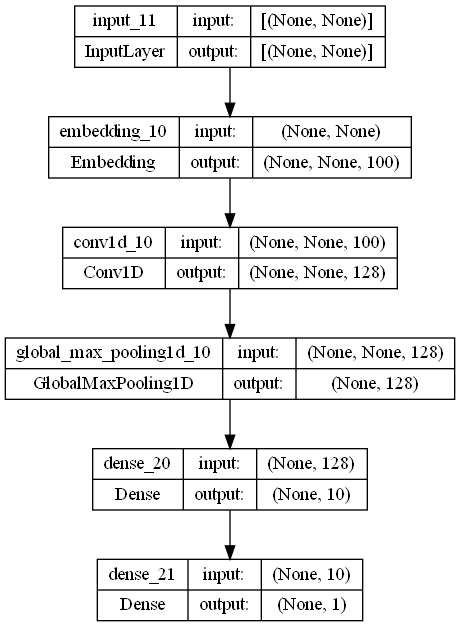

In [31]:
# Plot last model
plot_model(cnn,
           to_file="models/cnn_model.png",
           show_shapes=True,
           show_dtype=False,
           show_layer_names=True,
           rankdir="TB", # LR = horizontal, TB = vertical
           expand_nested=False,
           dpi=96,
           layer_range=None, # if you only want to plot some layers, specify them here
           show_layer_activations=False
           )

In [48]:
# Prepare synthetic data

# load synthetic data
synth_data = pd.read_excel("g:/My Drive/ITC, 5th semester (Thesis)/Code/Github_code/create_synthetic_dataset/synthetic_data.xlsx")
X_synth = synth_data['text']

# preprocess synthetic data
X_synth_preproc = X_synth.apply(lambda text: utils.preprocess(text, stopwords=stop_words, to_string=True))

# tokenize and pad data
X_synth_tokenized = tokenizer.texts_to_sequences(X_synth_preproc)
X_synth_padded = pad_sequences(X_synth_tokenized, MAXLEN, padding="post")

with open("data/X_synthetic_data_prepared.pkl", "wb") as f:
    pickle.dump(X_synth_padded, f)

In [32]:
# Predict new sentences using the last model and return the average pred and probability

sent = "Kriminelle damer" # change sentence accordingly
proba = utils.predict_toxicity(sent, stop_words, tokenizer, MAXLEN, cnn)
print("Probability:", proba[0])
print("Prediction :", round(proba[0][0]))

1/1 [==============================] - 0s 42ms/step
Probability: [0.04919283]
Prediction : 0


In [35]:
# Predict new sentences using these 10 models and return the average pred and probability

sent = "Kriminelle damer" 
probas_F = []
preds_F = []

for i in range(1,11):
    print(i)
    model = tf.keras.models.load_model(f'models/initializations/cnn{i}.keras')
    proba, pred = utils.predict_toxicity(sent, stop_words, tokenizer, MAXLEN, model)
    probas_F.append(proba[0])
    preds_F.append(pred[0])

1
1/1 [==============================] - 0s 136ms/step
2
1/1 [==============================] - 0s 122ms/step
3
1/1 [==============================] - 0s 145ms/step
4
1/1 [==============================] - 0s 141ms/step
5
1/1 [==============================] - 0s 160ms/step
6
1/1 [==============================] - 0s 121ms/step
7
1/1 [==============================] - 0s 125ms/step
8
1/1 [==============================] - 0s 295ms/step
9
1/1 [==============================] - 0s 123ms/step
10
1/1 [==============================] - 0s 133ms/step


In [37]:
sent = "Kriminelle herrer" 
probas_M = []
preds_M = []

for i in range(1,11):
    print(i)
    model = tf.keras.models.load_model(f'models/initializations/cnn{i}.keras')
    proba, pred = utils.predict_toxicity(sent, stop_words, tokenizer, MAXLEN, model)
    probas_M.append(proba[0])
    preds_M.append(pred[0])

1
1/1 [==============================] - 0s 163ms/step
2
1/1 [==============================] - 0s 152ms/step
3
1/1 [==============================] - 0s 169ms/step
4
1/1 [==============================] - 0s 152ms/step
5
1/1 [==============================] - 0s 134ms/step
6
1/1 [==============================] - 0s 125ms/step
7
1/1 [==============================] - 0s 131ms/step
8
1/1 [==============================] - 0s 131ms/step
9
1/1 [==============================] - 0s 131ms/step
10
1/1 [==============================] - 0s 120ms/step


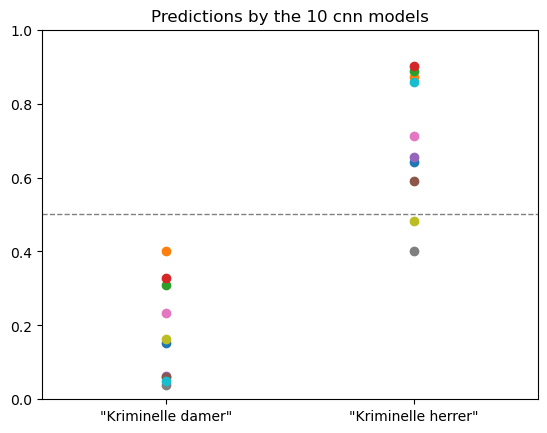

In [38]:
for x in probas_F:
    plt.scatter(1, x)
for x in probas_M:
    plt.scatter(2, x)
plt.xticks(ticks=[1,2], labels=['"Kriminelle damer"', '"Kriminelle herrer"'])
plt.title("Predictions by the 10 cnn models")
plt.xlim(0.5, 2.5)
plt.ylim(0, 1)
plt.hlines(0.5, xmin=0.5, xmax=2.5, ls="--", colors="grey", lw=1)
plt.show()

In [39]:
print("Female version:")
print("Avg. proba:", np.mean(probas_F))
print("Mode of preds:", mode(preds_F))
print("Label from avg. proba:", int(round(np.mean(probas_F))))
print()
print("Male version:")
print("Avg. proba:", np.mean(probas_M))
print("Mode of preds:", mode(preds_M))
print("Label from avg. proba:", int(round(np.mean(probas_M))))

Female version:
Avg. proba: 0.17995515
Mode of preds: 0
Label from avg. proba: 0

Male version:
Avg. proba: 0.7003207
Mode of preds: 1
Label from avg. proba: 1
